In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from datetime import date, datetime
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import itertools
import dask
from dask import delayed, compute
import time

[*********************100%%**********************]  7 of 7 completed


Ticker            AAPL        AMZN       GOOGL        META        MSFT  \
Date                                                                     
2014-01-02   19.754642   19.898500   27.855856   54.709999   37.160000   
2014-01-03   19.320715   19.822001   27.652653   54.560001   36.910000   
2014-01-06   19.426071   19.681499   27.960960   57.200001   36.130001   
2014-01-07   19.287144   19.901501   28.500000   57.919998   36.410000   
2014-01-08   19.409286   20.096001   28.559309   58.230000   35.759998   
...                ...         ...         ...         ...         ...   
2024-07-15  234.399994  192.720001  186.529999  496.160004  453.959991   
2024-07-16  234.820007  193.020004  183.919998  489.790009  449.519989   
2024-07-17  228.880005  187.929993  181.020004  461.989990  443.519989   
2024-07-18  224.179993  183.750000  177.690002  475.850006  440.369995   
2024-07-19  224.309998  183.130005  177.660004  476.790009  437.109985   

Ticker            NVDA        TSLA  


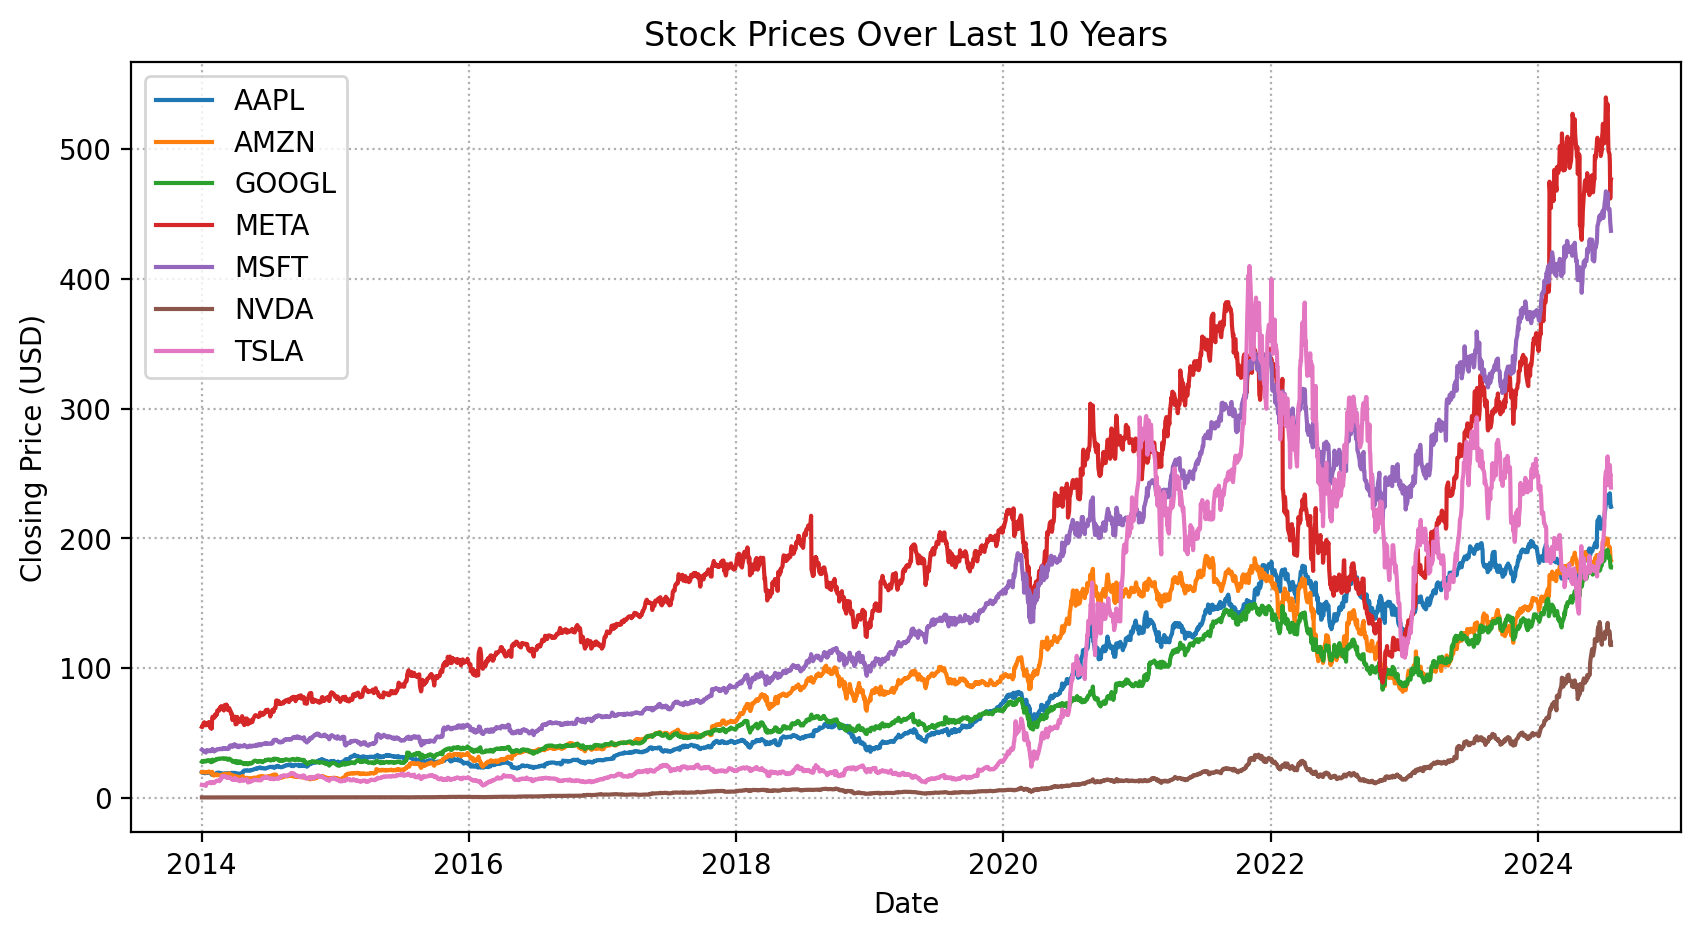

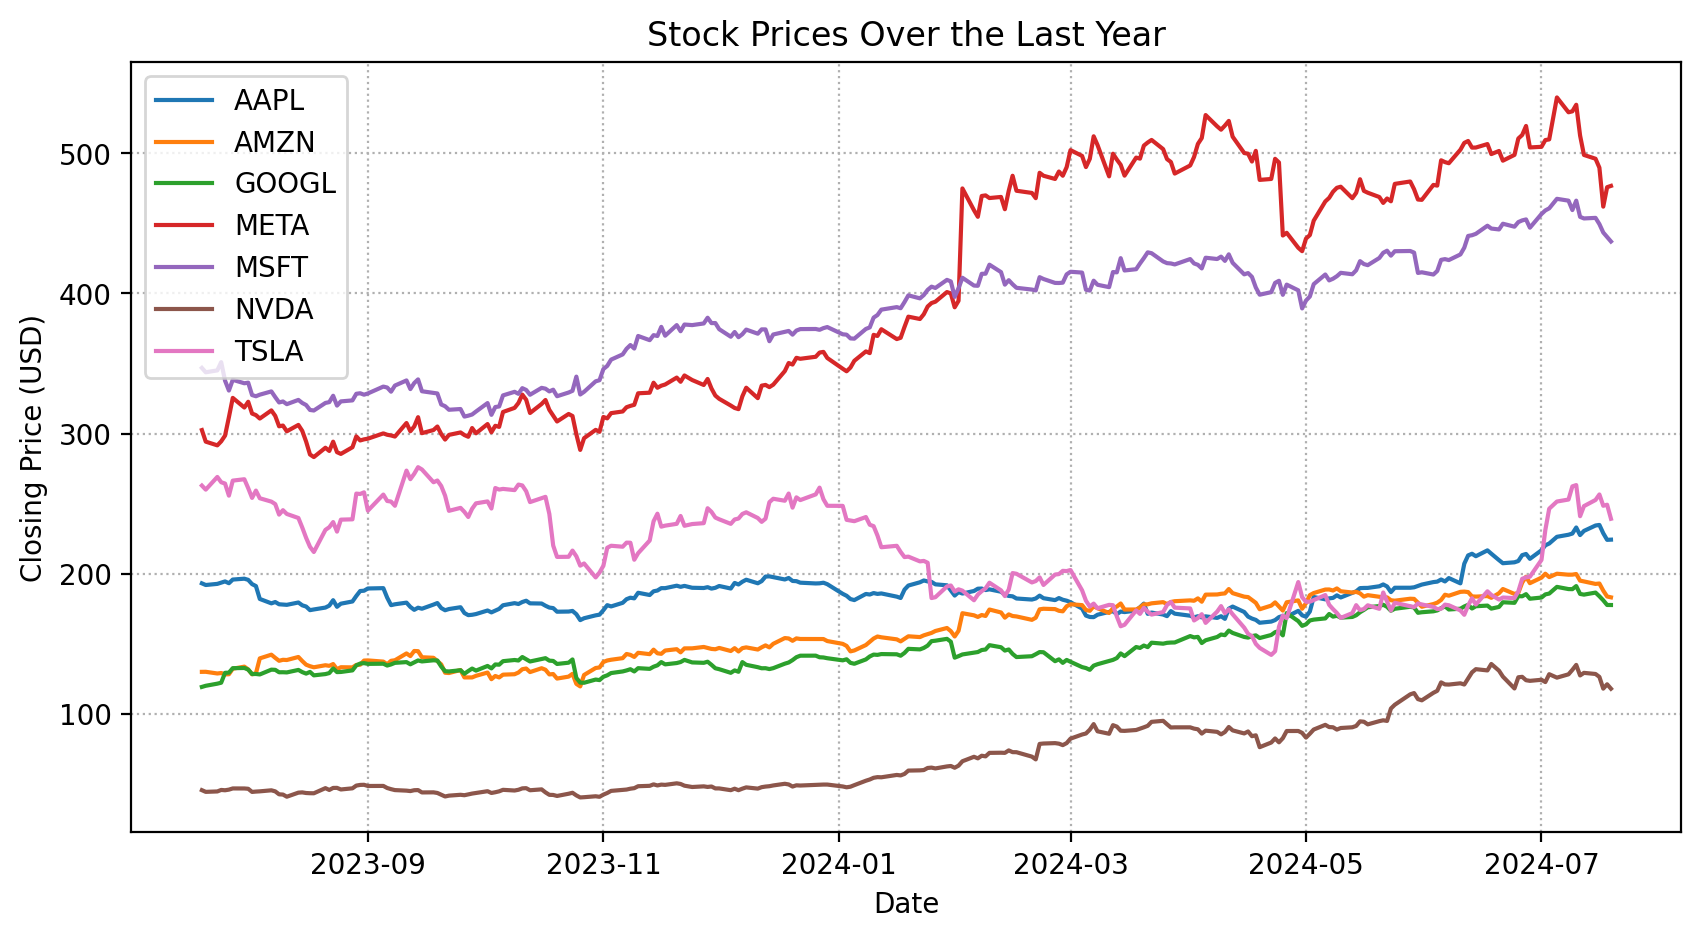

In [2]:
# Define the date range
start_date = '2014-01-01'
end_date = '2024-07-20'

# List of tickers to analyze
tickers = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

# Download stock price data for the specified tickers from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)["Close"]

# Data in which currency
CurrencyIN = yf.Tickers('MSFT').tickers['MSFT'].info['currency']

print(data)

# Plot all time series in one plot
plt.figure(figsize=(10,5), dpi=200)
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)

plt.title('Stock Prices Over Last 10 Years')
plt.xlabel('Date')
plt.ylabel(f'Closing Price ({CurrencyIN})')
plt.legend()
plt.grid(True, which='both', linestyle=':') 
plt.savefig("StockPrice10y.png")
plt.show()

# Filter the data for the last year
last_year_start_date = pd.to_datetime(end_date) - pd.DateOffset(years=1)
last_year_data = data[last_year_start_date:end_date]

# Plot time series for the last year
plt.figure(figsize=(10,5), dpi=200)
for ticker in tickers:
    plt.plot(last_year_data.index, last_year_data[ticker], label=ticker)

plt.title('Stock Prices Over the Last Year')
plt.xlabel('Date')
plt.ylabel(f'Closing Price ({CurrencyIN})')
plt.legend()
plt.grid(True, which='both', linestyle=':') 
plt.savefig("StockPrice1y.png")
plt.show()

# Granger causality

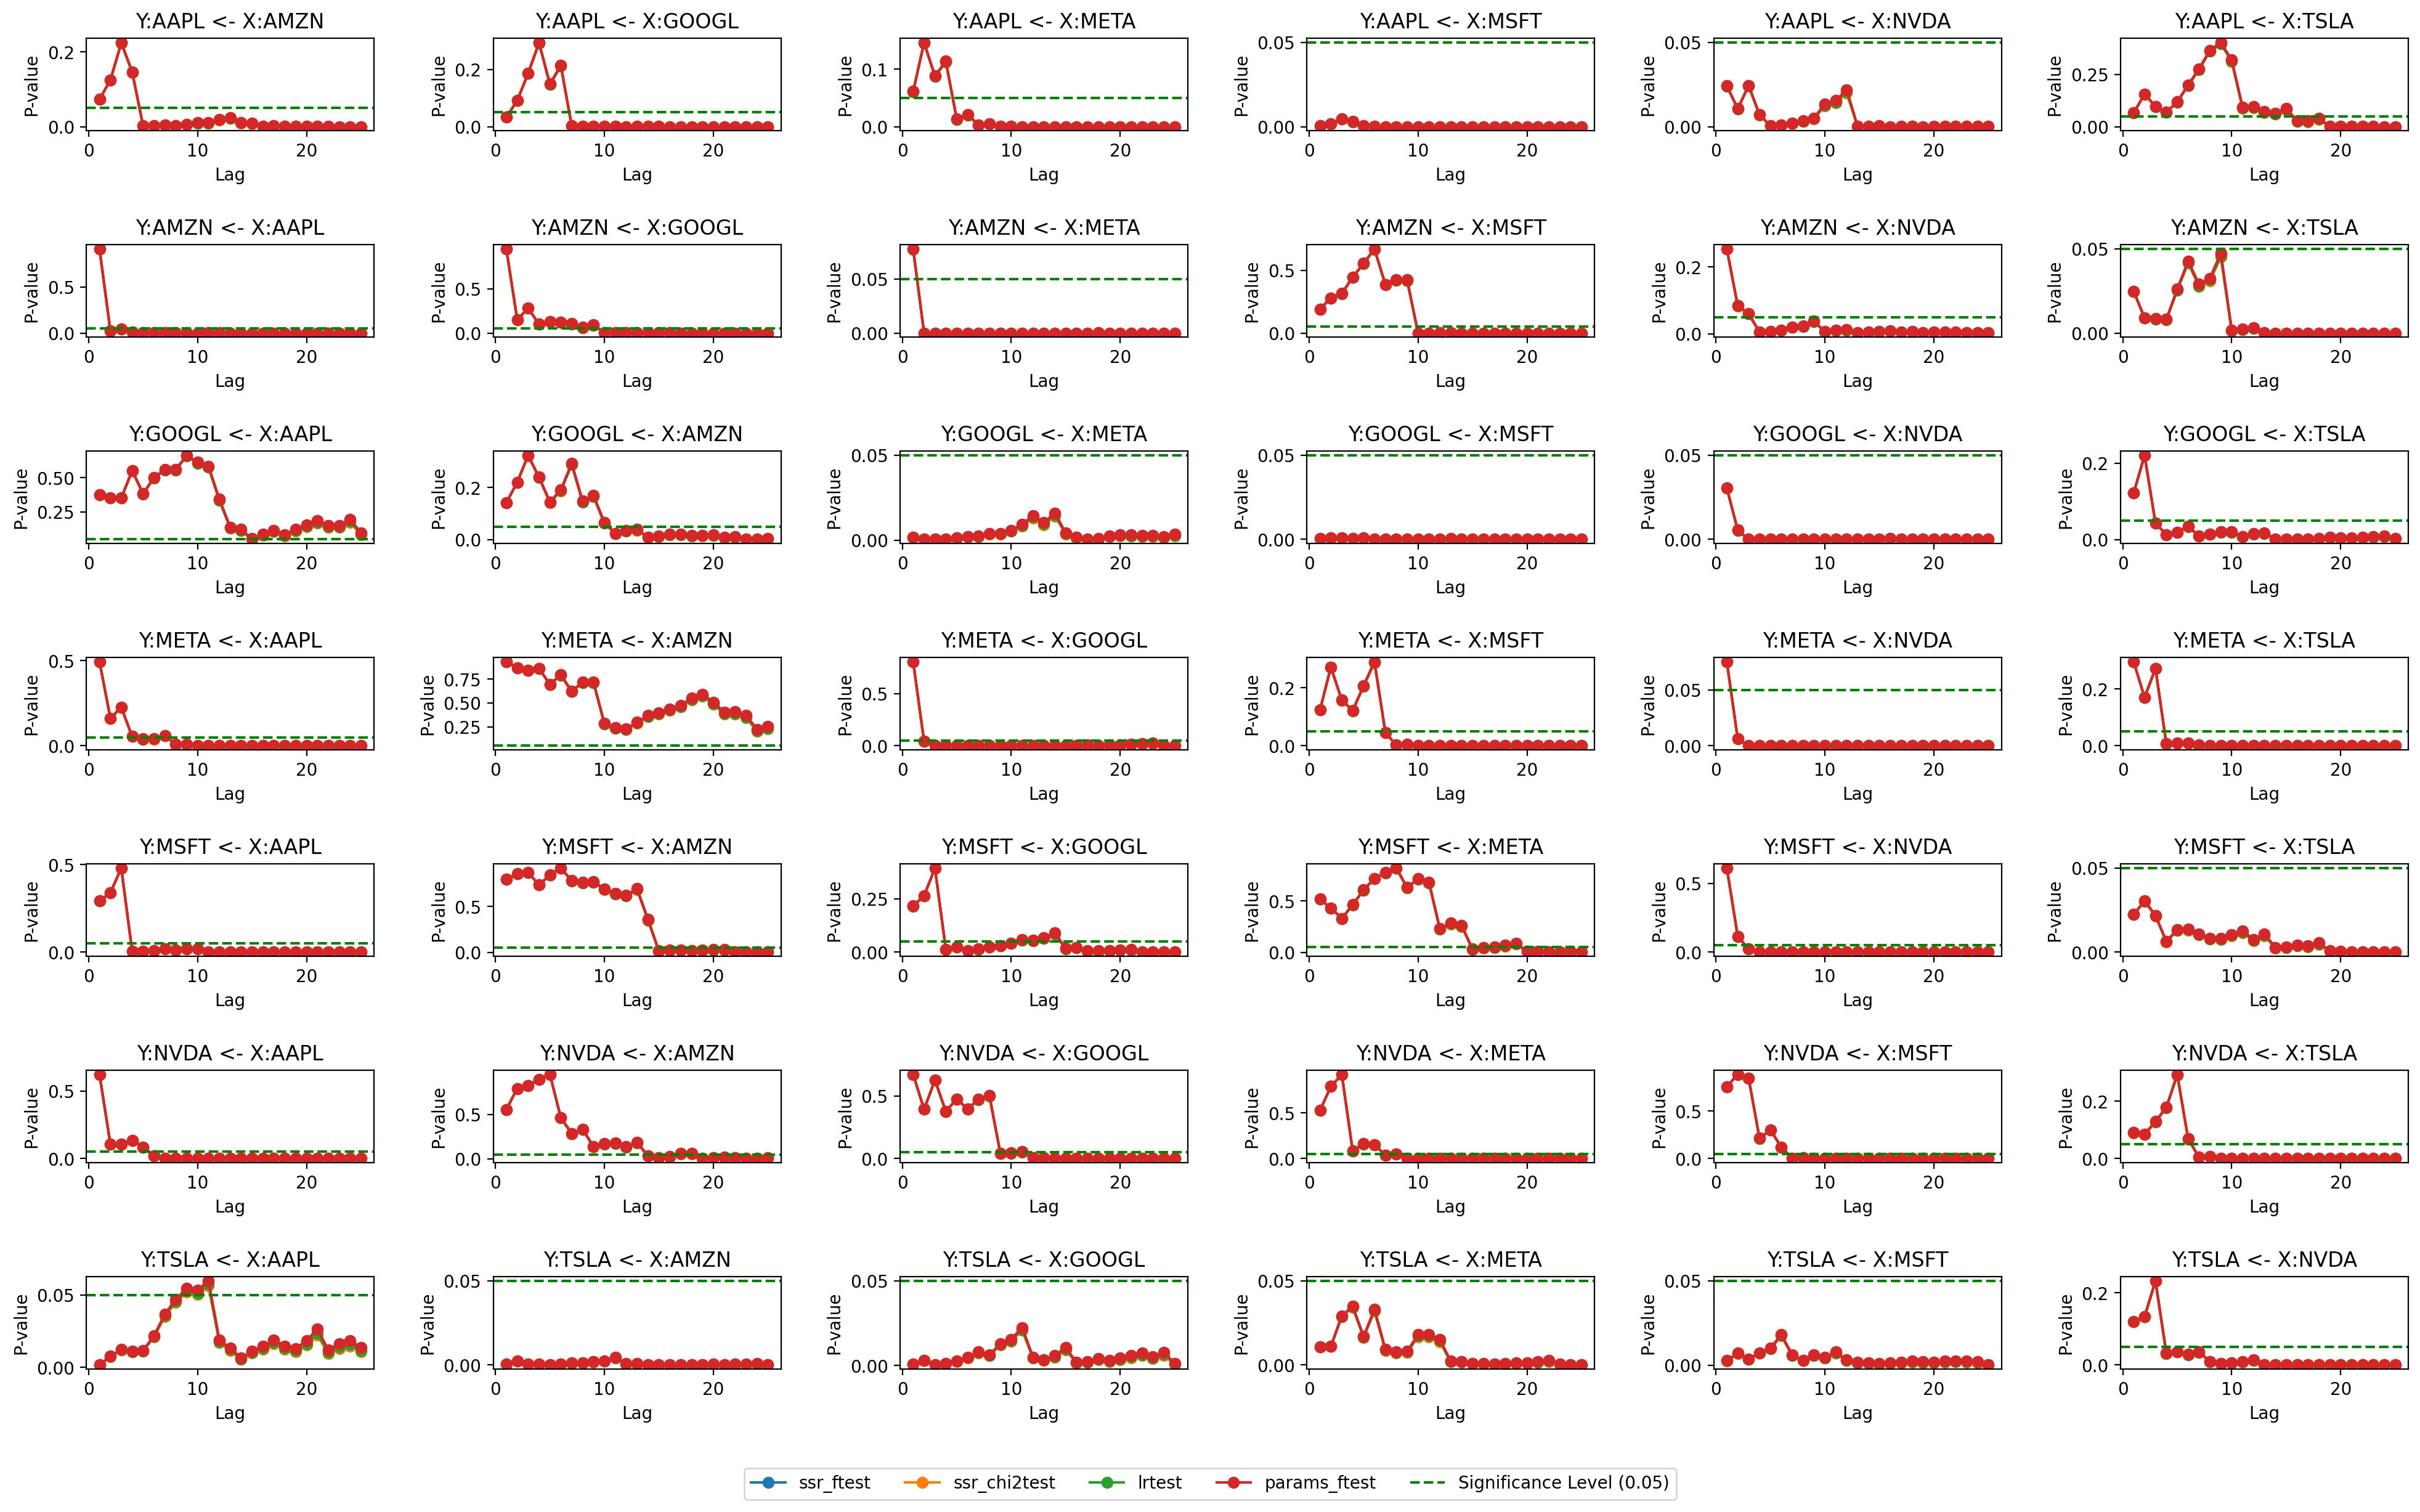

In [3]:
# Suppress the FutureWarning from grangercausalitytests
warnings.filterwarnings("ignore", category=FutureWarning, module='statsmodels.tsa.stattools')

def plot_granger_causality(data, col1, col2, max_lag=10, ax=None):
    # Perform Granger Causality Test
    test_result = grangercausalitytests(data[[col1, col2]], maxlag=max_lag, verbose=False)
    
    # Extract p-values
    p_values = {test: [] for test in ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest']}
    for lag in range(1, max_lag + 1):
        for test in p_values.keys():
            p_value = test_result[lag][0][test][1]
            p_values[test].append(p_value)
    
    # Plot p-values against lags
    lags = list(range(1, max_lag + 1))
    for test, values in p_values.items():
        ax.plot(lags, values, marker='o', label=test)
    
    ax.axhline(y=0.05, color='g', linestyle='--', label='Significance Level (0.05)')
    ax.set_xlabel('Lag')
    ax.set_ylabel('P-value')
    ax.set_title(f'Y:{col1} <- X:{col2}')
    

n_pairs = len(tickers) * (len(tickers) - 1)
ncols = len(tickers) - 1  # Number of columns in the plot grid
nrows = (n_pairs + ncols - 1) // ncols  # Number of rows in the plot grid

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12), dpi=200)
axs = axs.flatten()

plot_index = 0
for i in range(len(tickers)):
    for j in range(len(tickers)):
        if i != j:
            col1 = tickers[i]
            col2 = tickers[j]
            plot_granger_causality(data, col1, col2, max_lag=25, ax=axs[plot_index])
            plot_index += 1

# Collect handles and labels for the common legend
handles, labels = axs[0].get_legend_handles_labels()
# Create a common legend
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.002))

plt.tight_layout(pad=2.0, rect=[0, 0, 1, 1])  # Adjust the rect to leave space for the common legend
plt.savefig("GC.png", bbox_inches='tight')  # Save the plot with tight bounding box
plt.show()

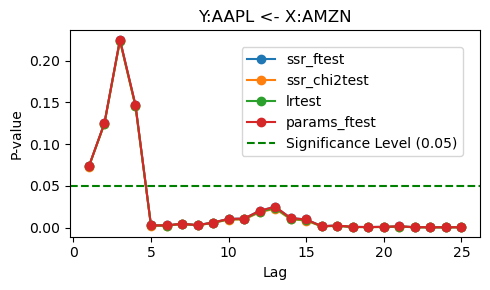

In [4]:
# "AAPL" vs "AMZN" for presentation
fig, ax = plt.subplots(figsize=(5, 3))
plot_granger_causality(data, "AAPL", "AMZN", max_lag=25, ax=ax)

# Create a common legend
fig.legend(handles, labels,  ncol=1, bbox_to_anchor=(0.95, 0.85))

plt.tight_layout()
plt.savefig("GC_AAPL_AMZN.png", bbox_inches='tight')  # Save the plot with tight bounding box
plt.show()

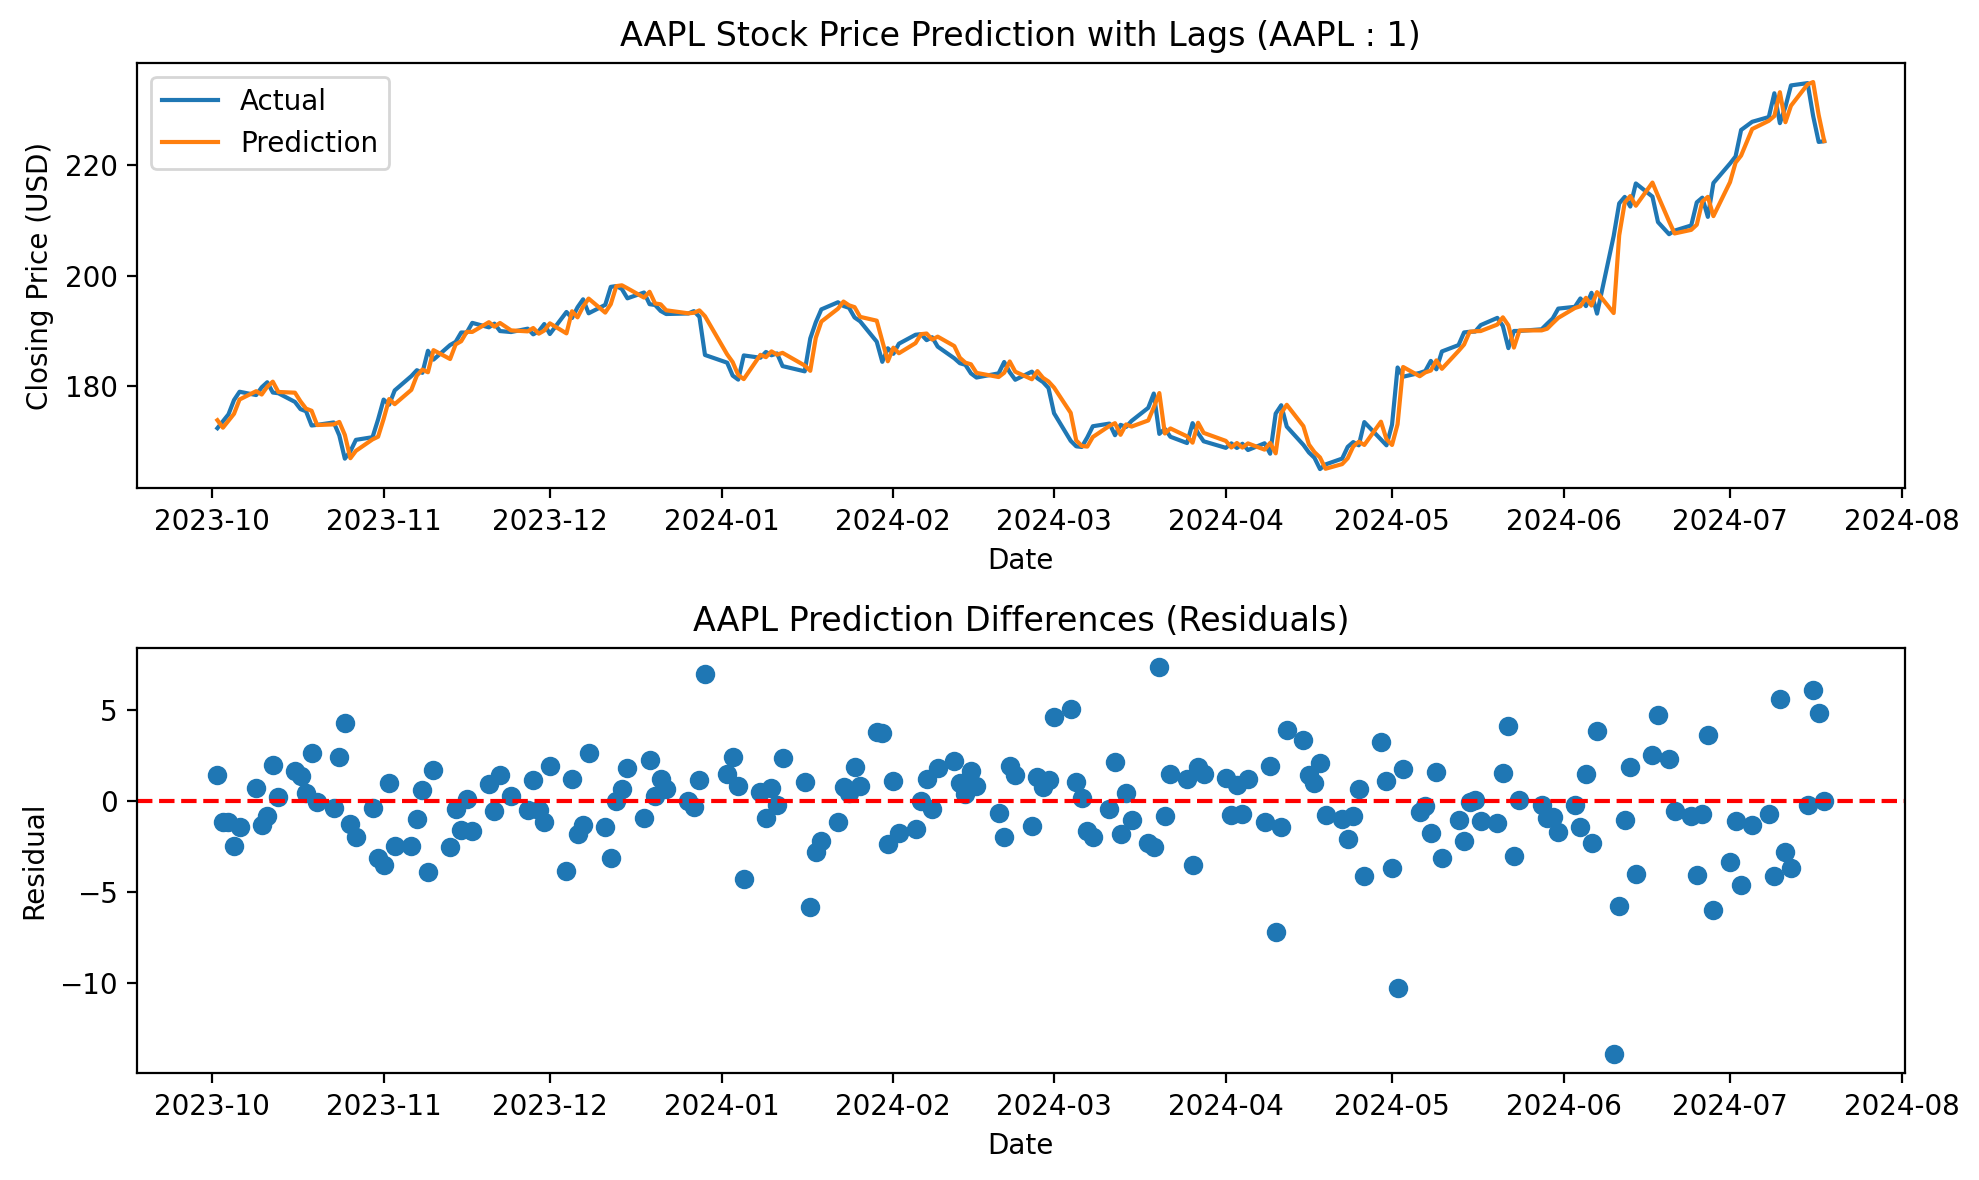

{'plot_out': <module 'matplotlib.pyplot' from '/home/kanna/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>,
 'RMSE': 37.548466402833945,
 'pred_df':           date            Prediction                Actual  \
 0   2023-10-02  [173.84247343367178]  [172.39999389648438]   
 1   2023-10-03   [172.4896737830195]  [173.66000366210938]   
 2   2023-10-04   [173.7519229704016]  [174.91000366210938]   
 3   2023-10-05  [175.00405936833351]  [177.49000549316406]   
 4   2023-10-06   [177.5893911915634]  [178.99000549316406]   
 ..         ...                   ...                   ...   
 195 2024-07-12   [230.7245132835745]  [234.39999389648438]   
 196 2024-07-15  [234.59473897007695]  [234.82000732421875]   
 197 2024-07-16  [235.01564581733612]   [228.8800048828125]   
 198 2024-07-17  [229.05866621281996]  [224.17999267578125]   
 199 2024-07-18    [224.345921912316]  [224.30999755859375]   
 
                  Difference  
 0      [1.4424795371874097]  
 1      [-1.170329

In [5]:
# Function to create lagged features for a time series
def XDmat(ts, lags, max_lag=None):
    """
    Creates lagged features from a time series.

    Parameters:
    - ts: Time series data.
    - lags: List of lag values to create as features.
    - max_lag: Maximum lag to consider.

    Returns:
    - Xout: Numpy array of lagged features.
    """
    ts = ts.values
    if max_lag is None:
        max_lag = max(lags)
    else:
        if max_lag < max(lags):
            raise ValueError("max_lag < max(lags) in XDmat()")
    indMX = np.arange(len(ts) - max_lag)
    Xout = np.zeros((len(ts) - max_lag, len(lags)))
    for i, lag in enumerate(lags):
        Xout[:, i] = ts[indMX + max_lag - lag]
    return Xout

# Function to predict stock prices using linear regression
def F7predict(predict_stock, cov_stock, data=data, days_used=2000, days_predict=200, PlotOut=False):
    """
    Predicts stock prices using linear regression.

    Parameters:
    - predict_stock: Ticker symbol of the stock to predict.
    - cov_stock: Dictionary with stock tickers as keys and lists of lag values as values.
    - data: DataFrame containing stock price data.
    - days_used: Number of days to use for training.
    - days_predict: Number of days to predict into the future.
    - PlotOut: Boolean flag to plot predictions and residuals.

    Returns:
    - Dictionary with plot object (if PlotOut=True), RMSE, predicted DataFrame, and cov_stock inword.
    """
    # Convert covariance to inword
    cov_stock_inword0 = []
    for key, values in cov_stock.items():
        cov_stock_inword0.append(f"({key} : {','.join(map(str, values))})")

    cov_stock_inword = " + ".join(cov_stock_inword0)

    # Determine the maximum lag
    max_lag = max(max(lags) for lags in cov_stock.values() if lags)
    
    # Prepare the target variable (Y)
    Y = data[predict_stock].dropna()
    Y = XDmat(Y, [0], max_lag)
    
    # Prepare the predictor variables (X)
    X = np.hstack([XDmat(data[stock].dropna(), lags, max_lag) for stock, lags in cov_stock.items() if lags])
    # Number of available data points
    N_avail = len(X)
    
    # Indices for the prediction period
    days_predict_i = np.arange(N_avail - days_predict, N_avail)
    
    # Lists to store predictions and actual values
    current_est = []
    current_obs = []
    
    # Perform predictions
    for i in range(days_predict):
        X0 = X[days_predict_i[i] - days_used:days_predict_i[i]]
        Y0 = Y[days_predict_i[i] - days_used:days_predict_i[i]]
        model = LinearRegression(fit_intercept=False).fit(X0, Y0)
        current_est.append(model.predict([X[days_predict_i[i]]])[0])
        current_obs.append(Y[days_predict_i[i]])
    
    # Create a DataFrame for predictions and actual values
    pred_df = pd.DataFrame({
        "date": data.index[days_predict_i],
        "Prediction": current_est,
        "Actual": current_obs
    })
    
    # Melt the DataFrame for plotting
    pred_long = pd.melt(pred_df, id_vars=["date"], 
                        value_vars=["Prediction", "Actual"], 
                        var_name="Type", value_name="price")

    if PlotOut :        
        # Create a figure and a set of subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), dpi=200)
        
        # Plot the predictions and actual values
        for label, df in pred_long.groupby("Type"):
            ax1.plot(df["date"], df["price"], label=label)
        ax1.set_title(f"{predict_stock} Stock Price Prediction with Lags {cov_stock_inword}")
        ax1.set_xlabel("Date")
        ax1.set_ylabel(f'Closing Price ({CurrencyIN})')
        ax1.legend()
        
        # Scatter plot of the differences (residuals)
        pred_df['Difference'] = pred_df['Prediction'] - pred_df['Actual']
        ax2.scatter(pred_df["date"], pred_df["Difference"])
        ax2.axhline(0, color='red', linestyle='--')
        ax2.set_xlabel("Date")
        ax2.set_ylabel("Residual")
        ax2.set_title(f"{predict_stock} Prediction Differences (Residuals)")
        
        # Save the combined plot with tight bounding box
        plt.tight_layout()
        plt.savefig(f"{predict_stock}.png", bbox_inches='tight')
        plt.show()
    
    # Calculate the root mean squared error (RMSE)
    rmse = np.sqrt(np.sum((pred_df["Prediction"] - pred_df["Actual"])**2))[0]
    
    return {"plot_out": plt, 
            "RMSE": rmse,
            "pred_df": pred_df, 
            "cov_stock_inword": cov_stock_inword}

# Example 
F7predict(predict_stock="AAPL", 
          cov_stock={"AAPL": [1]},
          data=data, 
          days_used=2000, 
          days_predict=200, 
          PlotOut=True)

# Include single lag

Elapsed time: 46.56758975982666 seconds


<Figure size 4400x2000 with 0 Axes>

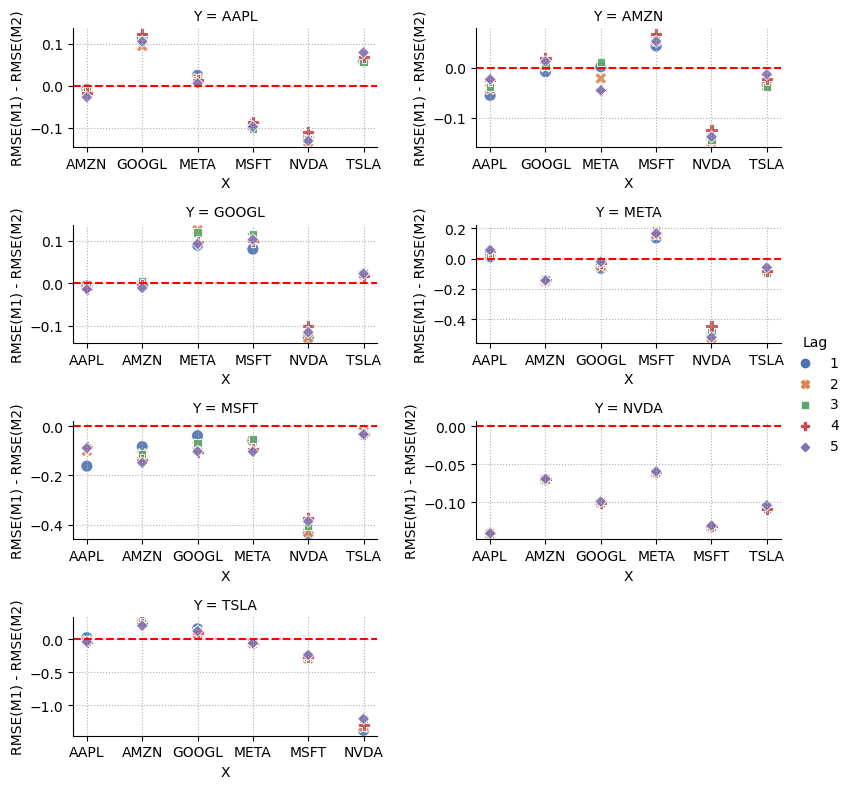

<Figure size 4400x2000 with 0 Axes>

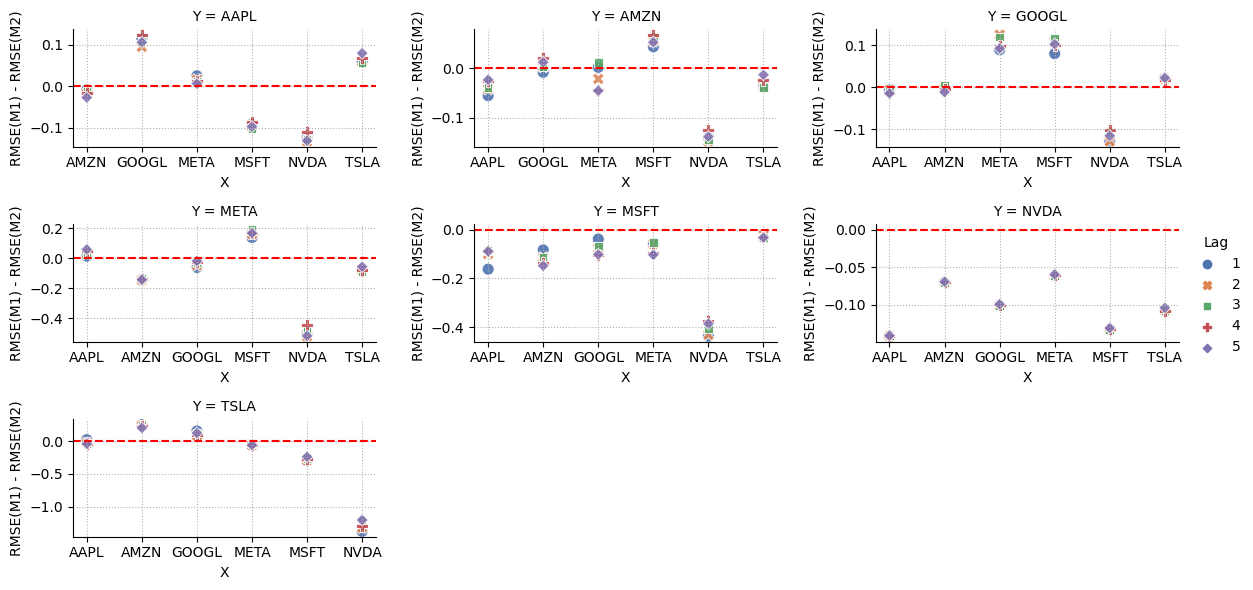

In [6]:
lag_upto = 5 # maximum lags for this project

# Define a function to perform the computation for a single lag
def compute_rmse_p(tickerY, tickerX, lag):
    """
    Compute RMSE from M1 and M2

    Parameters:
    - tickerY: Ticker symbol of the stock to predict.
    - tickerX: Ticker symbol of the stock as covariate.
    - lag: lag value.

    Returns:
    - Tuple with tickerY, tickerX, lag, RMSE from M1, RMSE from M2
    """
    cov_stock = {tickerY: [1], tickerX: [lag]}  # only the lag
    M1 = F7predict(predict_stock=tickerY, cov_stock={tickerY: [1]})
    M2 = F7predict(predict_stock=tickerY, cov_stock=cov_stock)
    
    return (tickerY, tickerX, lag, M1['RMSE'], M2['RMSE'])

# Define a function to plot the RMSE(M1) - RMSE(M2)
def plot_rmse_dif(RESULTS, pltnme, ncolPlot):
    """
    Plot the RMSE(M1) - RMSE(M2)

    Parameters:
    - RESULTS: DataFrame containing the results with columns ['Y', 'X', 'lagX', 'rmseM1', 'rmseM2'].
    - pltnme: Name of the plot to save as .png.
    - ncolPlot: Number of columns in the plot.

    Returns:
    - Saves a .png plot showing the difference in RMSE between M1 and M2 across different lag combinations.
    """
    # Calculate the difference in RMSE between M1 and M2
    RESULTS["RMSE(M1) - RMSE(M2)"] = RESULTS["rmseM1"] - RESULTS["rmseM2"]
    
    # Plot the difference in RMSE across different lag combinations for each stock
    fig = plt.figure(figsize=(22, 10), dpi=200)  # specify width and height in inches
    
    # Create the plot
    g = sns.FacetGrid(RESULTS, col="Y", col_wrap=ncolPlot, sharex=False, sharey=False, height=2, aspect=2)
    g.map_dataframe(lambda data, color: sns.scatterplot(data=data, x="X", y="RMSE(M1) - RMSE(M2)", 
                                                        hue="lagX", style="lagX", palette="deep", legend="full", s=75, alpha=0.9))
    
    
    # Add a horizontal line at y=0 for reference and rotate xticklabels
    for ax in g.axes.flat:
        ax.axhline(y=0, color='red', linestyle='dashed')
        plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
        ax.grid(True, which='both', linestyle=':') 
    
    # Adjust the legend
    g.add_legend(title="Lag")
    g.savefig(f"{pltnme}.png")
    
    # Show the plot
    plt.show()



# Create a list to store delayed computations
delayed_results_p = []

# Iterate over each combination of Y (predict_stock) and X (cov_stock)
for tickerY in tickers:
    for tickerX in [ticker for ticker in tickers if ticker != tickerY]:
        for lag in range(1, (lag_upto+1)):
            # Append delayed computation to the list
            delayed_results_p.append(delayed(compute_rmse_p)(tickerY, tickerX, lag))

# Record the start time
start_time = time.time()

# Compute the results in parallel
results_p = compute(*delayed_results_p)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

# Initialize lists to store results
tickerY_col = []
tickerX_col = []
lagX = []
rmseM1 = []
rmseM2 = []

# Extract results
for result in results_p:
    tickerY_col.append(result[0])
    tickerX_col.append(result[1])
    lagX.append(result[2])
    rmseM1.append(result[3])
    rmseM2.append(result[4])

# Convert results to a DataFrame
RESULTS = pd.DataFrame({
    'Y': tickerY_col,
    'X': tickerX_col,
    'lagX': lagX,
    'rmseM1': rmseM1,
    'rmseM2': rmseM2
})

# Plot the RMSE difference
plot_rmse_dif(RESULTS,"RMSEdif_p",ncolPlot=2)
plot_rmse_dif(RESULTS,"RMSEdif_p_forReport",ncolPlot=3)

# Include multiple lags

Elapsed time: 121.114004611969 seconds


<Figure size 4400x2000 with 0 Axes>

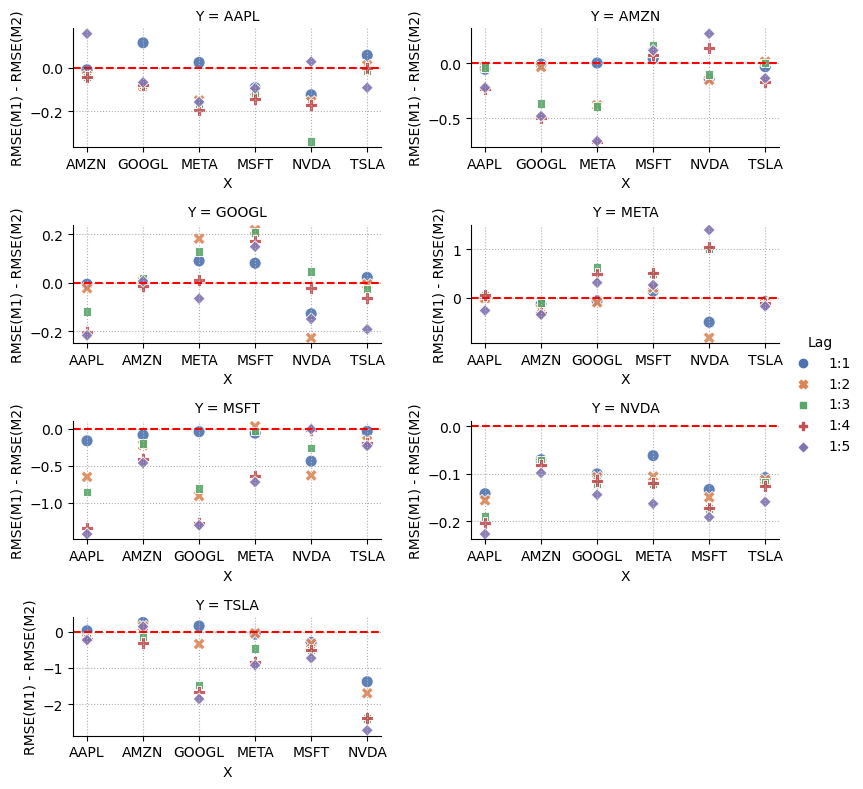

<Figure size 4400x2000 with 0 Axes>

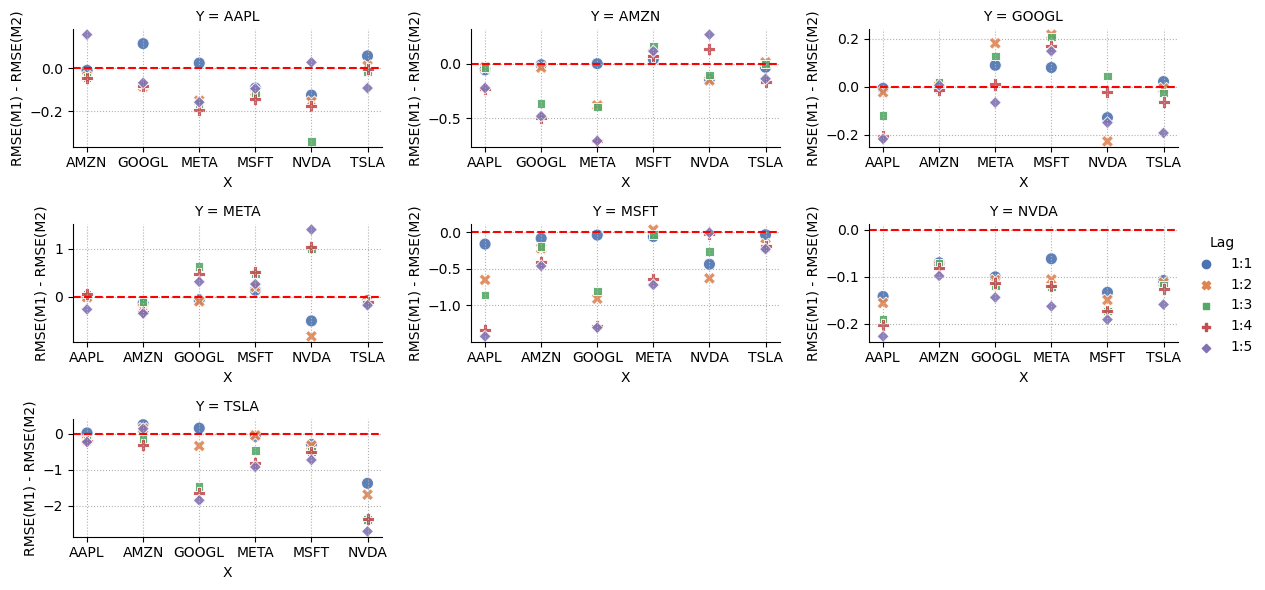

In [7]:
# Define a function to perform the computation for 1:lag
def compute_rmse_1_p(tickerY, tickerX, lag):
    """
    Compute RMSE from M1 and M2

    Parameters:
    - tickerY: Ticker symbol of the stock to predict.
    - tickerX: Ticker symbol of the stock as covariate.
    - lag: lag value.

    Returns:
    - Tuple with tickerY, tickerX, lag, RMSE from M1, RMSE from M2
    """
    cov_stock = {tickerY: [1], tickerX: list(range(1,lag+1)) }  # 1:lag
    M1 = F7predict(predict_stock=tickerY, cov_stock={tickerY: [1]})
    M2 = F7predict(predict_stock=tickerY, cov_stock=cov_stock)
    
    return (tickerY, tickerX, f'1:{lag}', M1['RMSE'], M2['RMSE'])




# Create a list to store delayed computations
delayed_results_1_p = []

# Iterate over each combination of Y (predict_stock) and X (cov_stock)
for tickerY in tickers:
    for tickerX in [ticker for ticker in tickers if ticker != tickerY]:
        for lag in range(1, (lag_upto+1)):
            # Append delayed computation to the list
            delayed_results_1_p.append(delayed(compute_rmse_1_p)(tickerY, tickerX, lag))

# Record the start time
start_time = time.time()

# Compute the results in parallel
results_1_p = compute(*delayed_results_1_p)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

# Initialize lists to store results
tickerY_col = []
tickerX_col = []
lagX = []
rmseM1 = []
rmseM2 = []

# Extract results
for result in results_1_p:
    tickerY_col.append(result[0])
    tickerX_col.append(result[1])
    lagX.append(result[2])
    rmseM1.append(result[3])
    rmseM2.append(result[4])

# Convert results to a DataFrame
RESULTS = pd.DataFrame({
    'Y': tickerY_col,
    'X': tickerX_col,
    'lagX': lagX,
    'rmseM1': rmseM1,
    'rmseM2': rmseM2
})

# Plot the RMSE difference
plot_rmse_dif(RESULTS,"RMSEdif_1:p",ncolPlot=2)
plot_rmse_dif(RESULTS,"RMSEdif_1:p_forReport",ncolPlot=3)

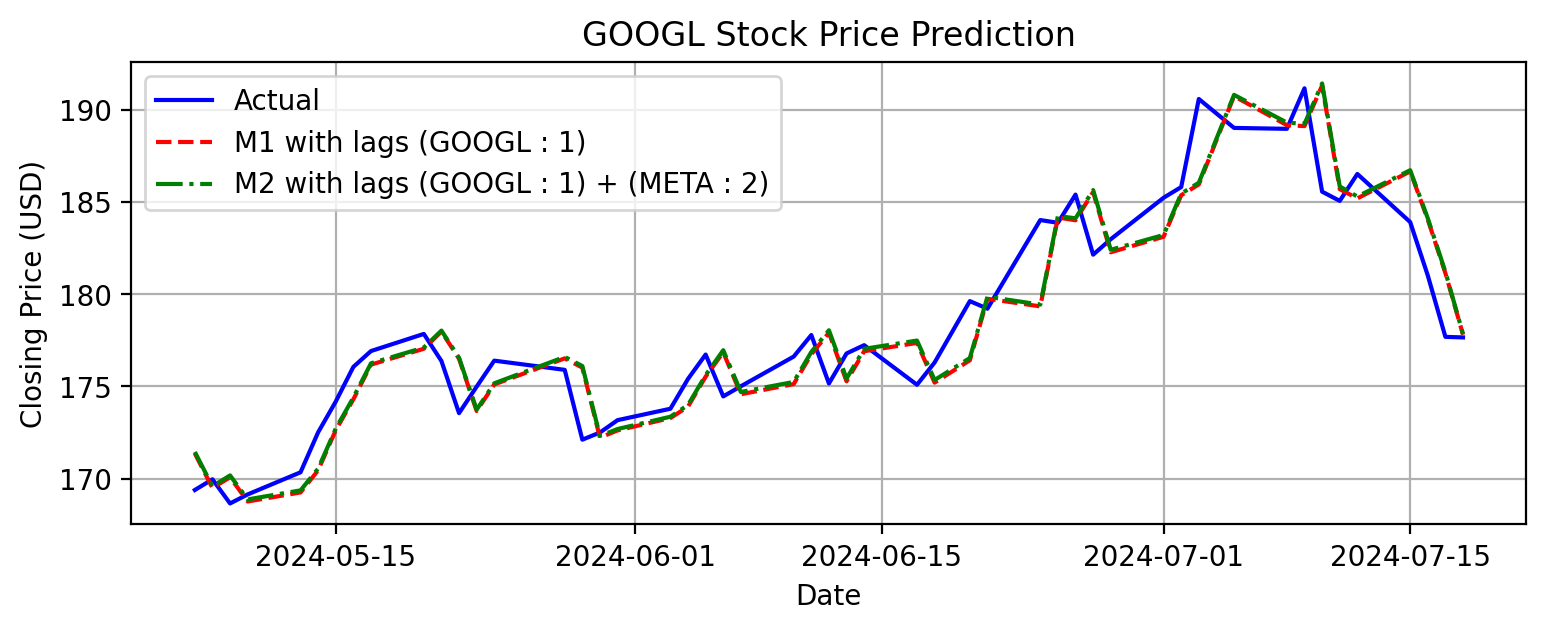

RMSE 2.11145(M1) --> 2.10981(M2)
Percentage of |M2_error| < |M1_error| = 60.00%


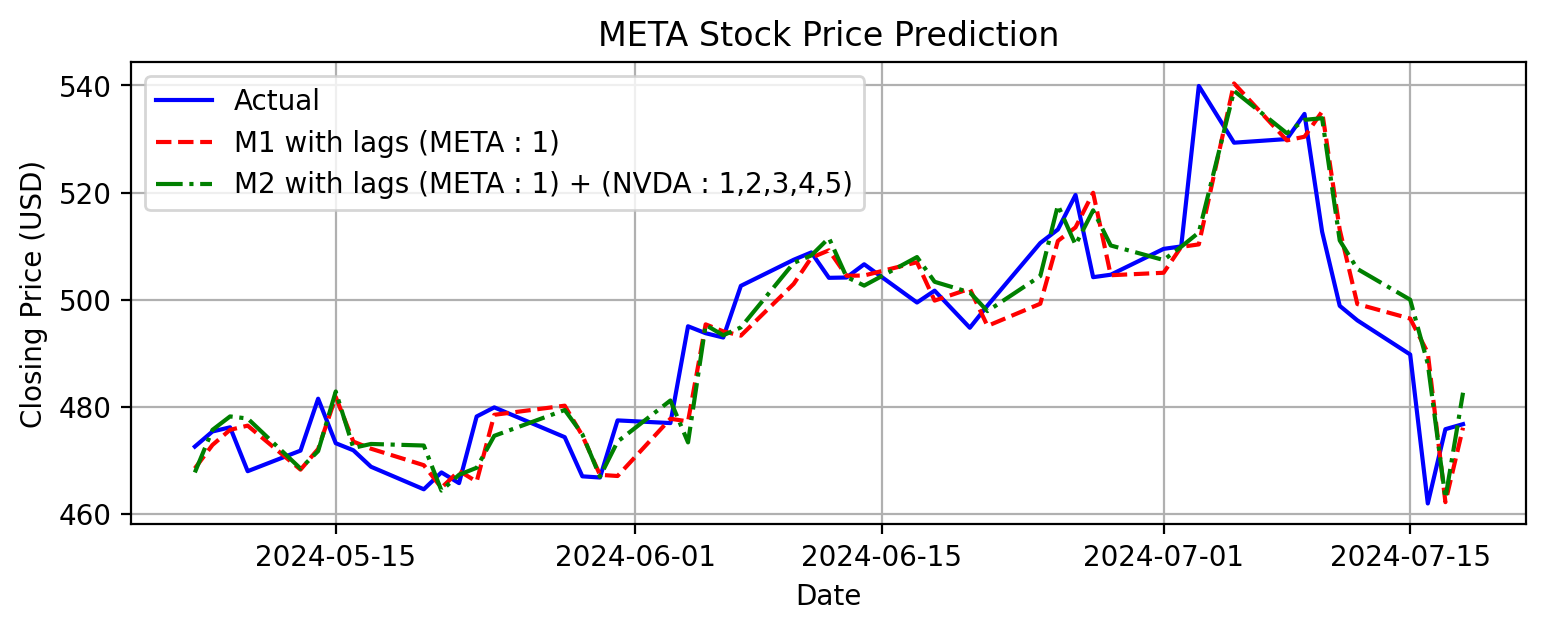

RMSE 9.42621(M1) --> 9.21014(M2)
Percentage of |M2_error| < |M1_error| = 56.00%


In [8]:
def F7predict_compare(predict_stock, cov_stockM1, cov_stockM2, PlotName=None):
    """
    Compares predictions between two models (M1 and M2) for a given stock.

    Parameters:
    - predict_stock: Ticker symbol of the stock to predict.
    - cov_stockM1: Dictionary with stock tickers as keys and lag values as values for M1.
    - cov_stockM2: Dictionary with stock tickers as keys and lag values as values for M2.

    Returns:
    - None (plots predictions and prints RMSE and percentage comparison).
    """
    # Predict using models M1 and M2
    M1 = F7predict(predict_stock=predict_stock, cov_stock=cov_stockM1)
    M2 = F7predict(predict_stock=predict_stock, cov_stock=cov_stockM2)
    
    # Copy prediction DataFrame from M1 and add columns for M1 and M2 predictions
    M12 = M1['pred_df'].copy()
    M12["M1"] = M1['pred_df']["Prediction"]
    M12["M2"] = M2['pred_df']["Prediction"]
    
    # Convert date column to datetime format for plotting
    M12['date'] = pd.to_datetime(M12['date'])
    
    # Select the last n number of rows for plotting
    M12 = M12.tail(50)
    
    # Plotting the data
    plt.figure(figsize=(9, 3), dpi=200)
    plt.plot(M12['date'], M12['Actual'], label='Actual', color='blue', linestyle='-')
    plt.plot(M12['date'], M12['M1'], label=f"M1 with lags {M1['cov_stock_inword']}", color='red', linestyle='--')
    plt.plot(M12['date'], M12['M2'], label=f"M2 with lags {M2['cov_stock_inword']}", color='green', linestyle='-.')
    plt.xlabel('Date')
    plt.ylabel(f'Closing Price ({CurrencyIN})')
    plt.title(f"{predict_stock} Stock Price Prediction")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{PlotName}.png", bbox_inches='tight')
    plt.show()
    
    # Calculate RMSE for M1 and M2
    rmseM1 = np.sqrt(np.mean((M12['M1'] - M12['Actual'])**2))
    rmseM2 = np.sqrt(np.mean((M12['M2'] - M12['Actual'])**2))
    
    # Calculate percentage of instances where M2 error is less than M1 error
    percentage = (abs(M12['M2'] - M12['Actual']) < abs(M12['M1'] - M12['Actual'])).mean() * 100
    
    # Print RMSE and percentage comparison
    print(f"RMSE {rmseM1[0]:.5f}(M1) --> {rmseM2[0]:.5f}(M2)")
    print(f"Percentage of |M2_error| < |M1_error| = {percentage:.2f}%")

# Examples 
F7predict_compare(predict_stock="GOOGL", 
                  cov_stockM1={"GOOGL" : [1]}, 
                  cov_stockM2={"GOOGL" : [1], "META" : [2]},PlotName="Example1")

F7predict_compare(predict_stock="META", 
                  cov_stockM1={"META" : [1]}, 
                  cov_stockM2={"META" : [1], "NVDA" : list(range(1,5+1))},PlotName="Example2")

